In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

In [4]:
import scipy.stats as stats

## 1. Create the dataset

In [7]:
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack( (  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                         1+np.ones( (nPerClust))  ) )

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# note: "long" format for CCE :Multiclass classification
labels = torch.tensor(labels_np).long()    

## 2. Data Visualization

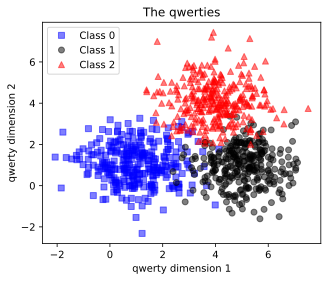

In [8]:
# show the data
fig = plt.figure(figsize=(5,4) ,dpi = 140)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',
         alpha=.5 , label = "Class 0")
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',
         alpha=.5 ,label = "Class 1")
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',
         alpha=.5 ,label = "Class 2")

plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

## 3. Convert the Data into Tensor Dataset

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [10]:
# scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects

batchsize    = 16 
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True  ,drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0] ) 

## 3. Create and validate the model

In [11]:
# create a class for the model
def createQwertyNet_Momentum(LR ,Momentum):

    class qwertyNet(nn.Module):
        
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2,8)

            ### hidden layer
            self.fc1 = nn.Linear(8,8)

            ### output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Hidden Layer
            x = F.relu( self.fc1(x) )
            
            return self.output(x)

    # create the model instance
    ANN_model = qwertyNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR ,momentum = Momentum)

    return ANN_model,lossfunc,optimizer

In [12]:
# test the model with fake input

test_model , lf , opt = createQwertyNet_Momentum(LR = 0.01 , Momentum = 0.9)
print(opt)

# input is ten samples
testinput = torch.rand(10,2)
test_model(testinput)

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


tensor([[-0.1659,  0.1196, -0.3115],
        [-0.1449,  0.1071, -0.3188],
        [-0.1353,  0.0838, -0.3366],
        [-0.1591,  0.0991, -0.3236],
        [-0.1588,  0.1120, -0.3121],
        [-0.1591,  0.0944, -0.3238],
        [-0.1670,  0.1081, -0.3136],
        [-0.1602,  0.1099, -0.3195],
        [-0.1392,  0.1031, -0.3243],
        [-0.1481,  0.1115, -0.3151]], grad_fn=<AddmmBackward0>)

## 4. Model Training

In [13]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , test_loader , epochs):


    # initialize losses
    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
         # Batch Training
        for X,y in train_loader:

            # forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # and get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # end epochs

    # function output
    return trainAcc,testAcc,losses,Model


## 5.  Run the Experiment 

In [15]:
# momentum values to use
momenta = [0,0.25,0.50,0.75,0.9,0.95,0.99,0.999]
LR = 0.01
num_epochs = 100

# Initialize results matrix
results = np.zeros((num_epochs,len(momenta),3))

# Test all momentum values on the same data (different model instances)
for idx,mom in enumerate(momenta):
    
    ANN_model,lossfunc,optimizer = createQwertyNet_Momentum(LR = LR ,Momentum = mom )
    
    TrainAcc,TestAcc,Losses,trained_Model = function2trainTheModel(Model = ANN_model , 
                                                                   lossfunc = lossfunc , 
                                                                   optimizer = optimizer ,
                                                                   train_loader = train_loader  , 
                                                                   test_loader = test_loader  , 
                                                                   epochs = num_epochs)
    
    # First layer of 3D matrix for losses (columns -> Different  Momentum)
    results[:,idx,0] = Losses 
    # Second layer of 3D matrix for TrainAcc (columns -> Different  Momentum)
    results[:,idx,1] = TrainAcc 
    # Third layer of 3D matrix  for TestAcc (columns -> Different  Momentum)
    results[:,idx,2] = TestAcc  

## 6. Plot the results

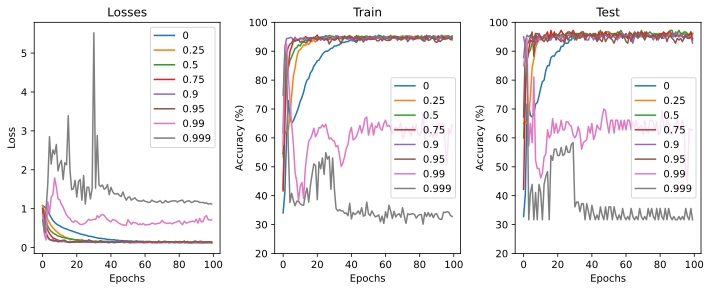

In [18]:
fig,ax = plt.subplots(1,3,figsize=(10,4))

for i in range(3):
    
    ax[i].plot(results[:,:,i])
    ax[i].legend(momenta)
    ax[i].set_xlabel('Epochs')
    
    if i==0:
        ax[i].set_ylabel('Loss')
    else:
        
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([20,100])

fig.tight_layout()

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()